# BAO examples

In this notebook we will show how to perform BAO fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk = cosmo.get_fourier().pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1001):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

## BAO likelihood

In [2]:
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, DampedBAOWigglesTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import setup_logging


template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template)
# Set damping sigmas to zero, as data follows linear pk
for param in theory.init.params.select(basename='sigma*'):
    param.update(value=0., fixed=True)
# Analytically solve for broadband parameters (named 'al*_*')
for param in theory.init.params.select(basename='al*_*'):
    param.update(derived='.auto') 
# Fix some broadband parameters (those with k^{-3} and k^{-2}) to speed up calculation in this notebook
for param in theory.init.params.select(basename=['al*_-3', 'al*_-2']):
    param.update(value=0., fixed=True)
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=mocks,
                                                     klim={0: [0.005, 0.2], 2: [0.005, 0.2]},  # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

setup_logging()

In [3]:
# Note, observable can take as input:
# - data: a (list of) (path to) PowerSpectrumStatistics object, flat array (see example below),
# or dictionary of parameters where to evaluate the theory to take as a mock data vector
# - covariance: a (list of) (path to) mocks, array (covariance matrix), or None (covariance passed to ObservablesGaussianLikelihood instead)

# Example, passing arrays:
ells = (0, 2)
k, pk = data(ell=ells, complex=False, return_k=True) # numpy array
mask = (k > 0.005) & (k < 0.2)
k = k[mask]  # array; one could also provide a list of k arrays, one for each ell
pk = np.ravel([pp[mask] for pp in pk])  # flat array
cov = np.cov([np.ravel([pp[mask] for pp in mock(ell=ells, complex=False)]) for mock in mocks], rowvar=False)  # array
observable = TracerPowerSpectrumMultipolesObservable(data=pk,
                                                     covariance=cov,
                                                     ells=ells,
                                                     k=k,
                                                     shotnoise=shotnoise,
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [4]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 3 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=3)

[000000.66] [0/1] 08-04 17:59  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper', 'b1'].


/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[000001.47] [0/1] 08-04 17:59  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].
[000001.50] [0/1] 08-04 17:59  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].


In [5]:
print(profiles.to_stats(tablefmt='pretty'))

+-------------------------------------+--------+---------+--------+
| chi2 / (38 - 9) = 23.38 / 29 = 0.81 | varied | bestfit | error  |
+-------------------------------------+--------+---------+--------+
|                qpar                 |  True  | 1.0009  | 0.0028 |
|                qper                 |  True  | 0.9943  | 0.0051 |
|                 b1                  |  True  |  1.960  | 0.034  |
|               al0_-1                |  True  |   400   |        |
|                al0_0                |  True  |  -160   |        |
|                al0_1                |  True  |   34    |        |
|               al2_-1                |  True  |   46    |        |
|                al2_0                |  True  |   -85   |        |
|                al2_1                |  True  |   35    |        |
+-------------------------------------+--------+---------+--------+


array([<Axes: ylabel='$q_{\\parallel}$'>, <Axes: ylabel='$q_{\\perp}$'>],
      dtype=object)

[000015.40] [0/1] 08-04 17:59  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000015.41] [0/1] 08-04 17:59  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000015.47] [0/1] 08-04 17:59  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000015.48] [0/1] 08-04 17:59  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


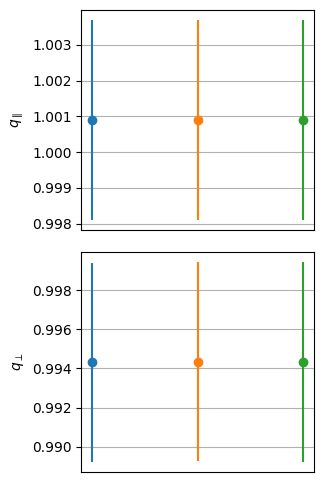

In [6]:
from desilike.samples import plotting
plotting.plot_aligned_stacked(profiles, params=['qpar', 'qper'])

[000015.51] [0/1] 08-04 17:59  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].
[000015.52] [0/1] 08-04 17:59  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].


array([<Axes: ylabel='$k \\Delta P_{0}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>,
       <Axes: xlabel='$k$ [$h/\\mathrm{Mpc}$]', ylabel='$k \\Delta P_{2}(k)$ [$(\\mathrm{Mpc}/h)^{2}$]'>],
      dtype=object)

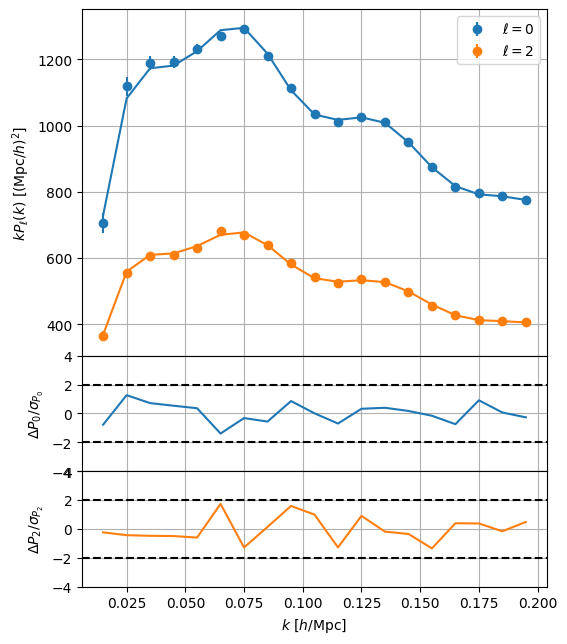

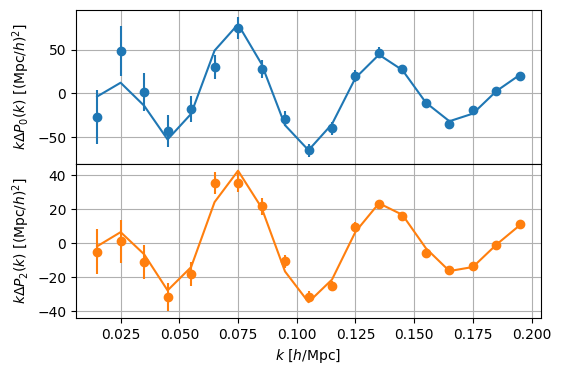

In [7]:
likelihood(**profiles.bestfit.choice(input=True))
observable.plot()
observable.plot_wiggles()

## Detection level

In [8]:
likelihood()
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso', only_now=True)
theory.init.update(template=template)

profiler = MinuitProfiler(likelihood, seed=42)
grid = np.linspace(0.8, 1.2, 31)
profiler.maximize(niterations=1)
profiler.profile(params=['qiso'], grid=grid)
profiles_nowiggle = profiler.profiles

[000017.11] [0/1] 08-04 17:59  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000017.15] [0/1] 08-04 17:59  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].
[000017.15] [0/1] 08-04 17:59  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].


/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


In [9]:
template.init.update(only_now=False)

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
print(profiler.profiles.to_stats(tablefmt='pretty'))

profiler.profile(params=['qiso'], grid=grid)
profiles = profiler.profiles

[000047.53] [0/1] 08-04 17:59  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].
[000047.56] [0/1] 08-04 17:59  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].
[000047.57] [0/1] 08-04 17:59  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1'].
+-------------------------------------+--------+---------+--------+
| chi2 / (38 - 8) = 26.68 / 30 = 0.89 | varied | bestfit | error  |
+-------------------------------------+--------+---------+--------+
|                qiso                 |  True  | 1.0023  | 0.0027 |
|                 b1                  |  True  |  1.981  | 0.032  |
|               al0_-1                |  True  |   370   |        |
|                al0_0                |  True  |  -300   |        |
|                al0_1                |  True  |   97    |        |
|               al2_-1                |  True  |   86    |        |
|

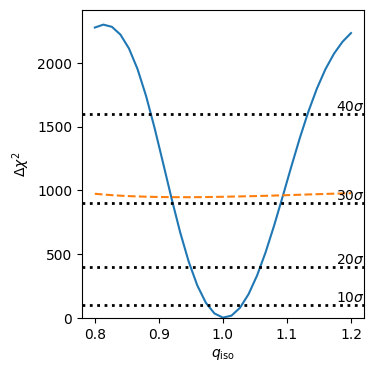

In [10]:
plotting.plot_profile_comparison(profiles, profiles_nowiggle, cl=[10, 20, 30, 40])
# Orange curve, which is no-wiggle, is not flat:
# some qiso information is picked up by the broadband because we did not include enough broadband terms

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [11]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, save_fn='_tests/chain_bao_*.npy', seed=42)
sampler.run(check={'max_eigen_gr': 0.1, 'stable_over': 1})

[000080.15] [0/1] 08-04 18:00  EmceeSampler              INFO     Varied parameters: ['qiso', 'b1'].
[000164.67] [0/1] 08-04 18:01  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[000164.68] [0/1] 08-04 18:01  EmceeSampler              INFO     Diagnostics:
[000164.70] [0/1] 08-04 18:01  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.13; not < 0.1.
[000164.71] [0/1] 08-04 18:01  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0985.
[000164.85] [0/1] 08-04 18:01  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.368.
[000164.86] [0/1] 08-04 18:01  EmceeSampler              INFO     - max Geweke is 0.308.
[000164.86] [0/1] 08-04 18:01  EmceeSampler              INFO     - Geweke p-value is 0.709.
[000164.87] [0/1] 08-04 18:01  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 14.2.


/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000251.86] [0/1] 08-04 18:03  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[000251.87] [0/1] 08-04 18:03  EmceeSampler              INFO     Diagnostics:
[000251.88] [0/1] 08-04 18:03  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.159; not < 0.1.
[000251.89] [0/1] 08-04 18:03  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.119.
[000252.14] [0/1] 08-04 18:03  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.285.
[000252.14] [0/1] 08-04 18:03  EmceeSampler              INFO     - max Geweke is 0.431.
[000252.14] [0/1] 08-04 18:03  EmceeSampler              INFO     - Geweke p-value is 0.729.
[000252.15] [0/1] 08-04 18:03  EmceeSampler              INFO     - (300 iterations / integrated autocorrelation time) is 13.8.
[000252.15] [0/1] 08-04 18:03  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.582.
[000339.49] [0/1] 08-04 18:04  Chain             

[Chain(shape=(1500, 6), params=ParameterCollection(['qiso', 'b1', 'logposterior', 'df', 'sigmas', 'sigmapar', 'sigmaper', 'al0_-1', 'al0_0', 'al0_1', 'al2_-1', 'al2_0', 'al2_1', 'loglikelihood', 'logprior']))]

In [12]:
chain = sampler.chains[0].remove_burnin(0.5)[::10]
print(chain.to_stats(tablefmt='pretty'))

+--------+--------+--------+--------+--------+-----------------+-----------------+
|        | argmax |  mean  | median |  std   | quantile:1sigma | interval:1sigma |
+--------+--------+--------+--------+--------+-----------------+-----------------+
|  qiso  | 1.0021 | 1.0026 | 1.0025 | 0.0025 | -0.0025/+0.0026 | -0.0022/+0.0029 |
|   b1   | 1.980  | 1.979  | 1.977  | 0.031  |  -0.032/+0.035  |  -0.034/+0.032  |
| al0_-1 |  370   |  410   |  400   |  360   |    -380/+380    |    -400/+370    |
| al0_0  |  -300  |  -310  |  -310  |  240   |    -250/+240    |    -250/+240    |
| al0_1  |   94   |   98   |   97   |   92   |    -90./+92     |     -91/+92     |
| al2_-1 |   80   |  100   |  100   |  110   |    -110/+110    |    -120/+110    |
| al2_0  |  -30   |  -40   |  -40   |  110   |    -110/+110    |    -110/+110    |
| al2_1  |   7    |  10.   |  10.   |  40.   |     -41/+41     |    -41/+40.     |
+--------+--------+--------+--------+--------+-----------------+-----------------+


Removed no burn in


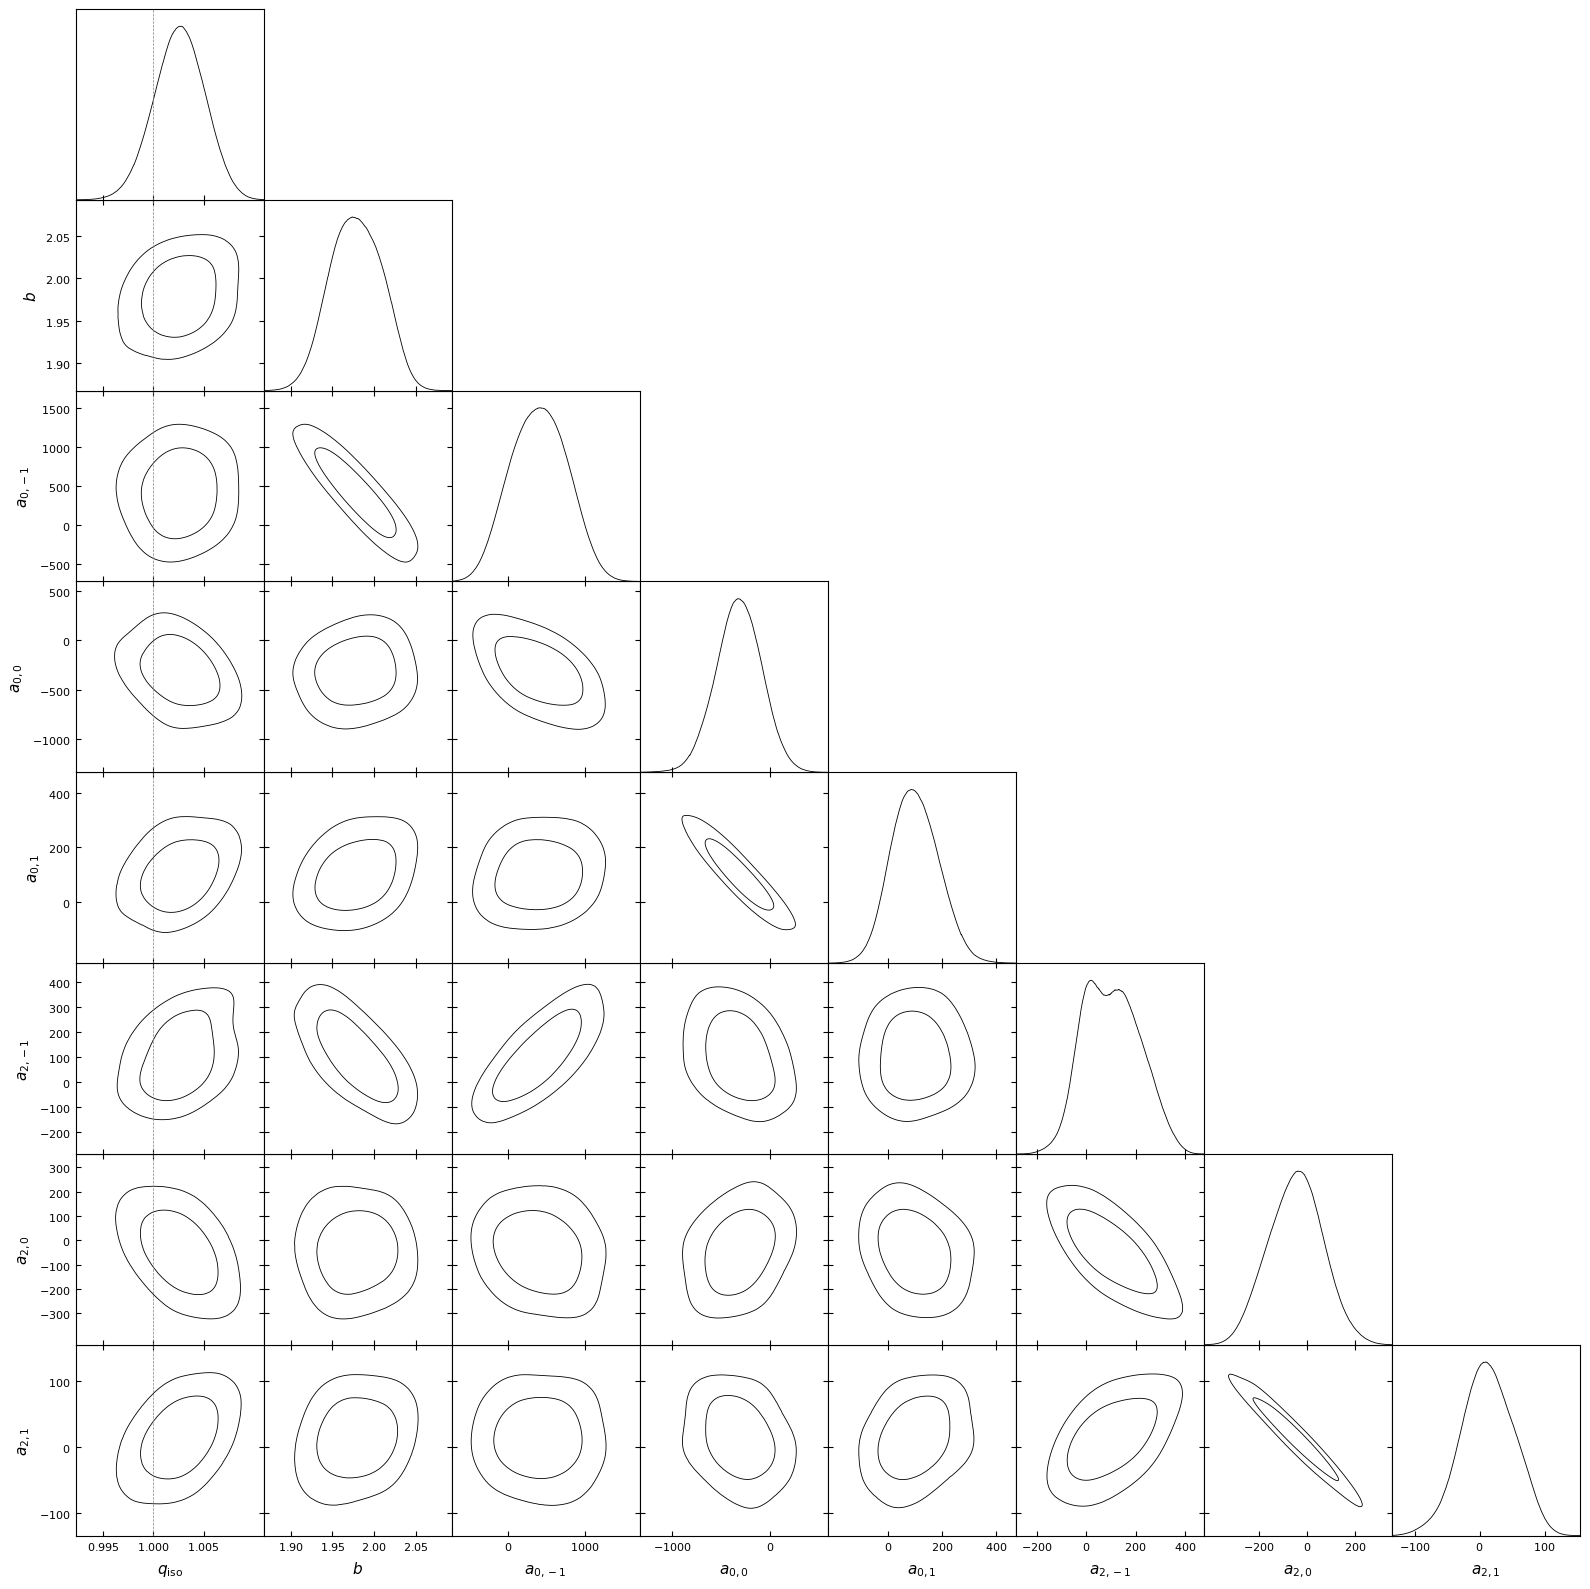

In [13]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'qiso': 1.})

## Post-processing
Let's use this BAO measurement to put constraints on $\Omega_{m}$.

In [14]:
from desilike.observables.galaxy_clustering import BAOCompressionObservable
observable = BAOCompressionObservable(data=chain, covariance=chain, z=z, quantities=['qiso'], fiducial='DESI')
likelihood = ObservablesGaussianLikelihood(observables=[observable])

In [15]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.02})

[000544.73] [0/1] 08-04 18:08  BAOCompressionObservable  INFO     Found quantities ['qiso'].
[000544.81] [0/1] 08-04 18:08  EmceeSampler              INFO     Varied parameters: ['Omega_m'].
[000612.23] [0/1] 08-04 18:09  EmceeSampler              INFO     Diagnostics:
[000612.24] [0/1] 08-04 18:09  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0744; not < 0.02.
[000612.24] [0/1] 08-04 18:09  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0744.
[000612.28] [0/1] 08-04 18:09  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.894.
[000612.28] [0/1] 08-04 18:09  EmceeSampler              INFO     - max Geweke is 0.506.
[000612.28] [0/1] 08-04 18:09  EmceeSampler              INFO     - Geweke p-value is nan.
[000612.28] [0/1] 08-04 18:09  EmceeSampler              INFO     - (150 iterations / integrated autocorrelation time) is 14.2.
[000679.07] [0/1] 08-04 18:10  EmceeSampler              INFO     Diagnostics:
[0

[Chain(shape=(2400, 4), params=ParameterCollection(['Omega_m', 'logposterior', 'loglikelihood', 'logprior']))]

Removed no burn in


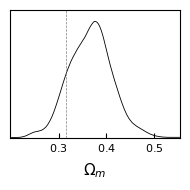

In [16]:
from desilike.samples import plotting
chain = sampler.chains[0].remove_burnin(0.4)
fiducial = observable.extractor.fiducial
plotting.plot_triangle(chain, markers={'Omega_m': fiducial.Omega0_m})